<a href="https://colab.research.google.com/github/NoahLee99/ML-DL-studylog/blob/main/%EB%A1%9C%EC%9D%B4%ED%84%B0_%EB%89%B4%EC%8A%A4_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
'''
실제로 인공지능이 문장을 학습한다는 것은 저번 장에서 공부한 내용과는 성질이 다소 다르다.
문장은 여러 개의 단어로 이루어져 있는데,
그 의미를 전달하려면 각 단어가 정해진 순서대로 입력되어야 하기 때문이다.
즉, 여러 데이터가 순서와 관계없이 입력되던 것과는 다르게,
이번에는 과거에 입력된 데이터와 나중에 입력된 데이터 사이의 관계를 고려해야 한다.

이를 해결하기 위해 "순환 신경망(Recurrent Neural Network, RNN)" 방법이 고안되었다.
순환 신경망은 여러 개의 데이터가 순서대로 입력되었을 때
앞서 입력 받은 데이터를 잠시 기억해 놓는 방법이다.
'''

'\n실제로 인공지능이 문장을 학습한다는 것은 저번 장에서 공부한 내용과는 성질이 다소 다르다.\n문장은 여러 개의 단어로 이루어져 있는데, \n그 의미를 전달하려면 각 단어가 정해진 순서대로 입력되어야 하기 때문이다.\n즉, 여러 데이터가 순서와 관계없이 입력되던 것과는 다르게,\n이번에는 과거에 입력된 데이터와 나중에 입력된 데이터 사이의 관계를 고려해야 한다.\n\n이를 해결하기 위해 "순환 신경망(Recurrent Neural Network, RNN)" 방법이 고안되었다.\n순환 신경망은 여러 개의 데이터가 순서대로 입력되었을 때 \n앞서 입력 받은 데이터를 잠시 기억해 놓는 방법이다.\n'

# LSTM을 이용한 이용한 로이터 뉴스 카테고리 분류하기

* **LSTM**이란 RNN의 기울기 소실 문제가 발생하는 단점을 보완하고자 등장한 방법이다.

* 즉, 기존의 RNN에 반복(순환)되기 직전 다음 층으로 기억된 값을 넘길지 여부를 <br> 관리하는 단계를 하나 더 추가한 것이다.

* 입력된 문장 의미를 파악하는 것은 곧 모든 단어를 종합해
<br> 하나의  카테고리로 분류하는 작업이다.

* 긴 텍스트를 읽고 이 데이터가 어떤 의미를 지니는지 카테고리로 분류해 보자.

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 로이토 뉴스 테이터셋 로드
from tensorflow.keras.datasets import reuters

# 훈련 세트와 테스트 세트로 분할
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000,
                                                         test_split=0.2)
# num_words=1000은 가장 빈번한 단어 1,000개만 사용한다는 의미 (빈도가 1~1000에 해당)

In [29]:
# 데이터 확인
category = np.max(y_train) + 1
# 뉴스 기사 카테고리 레이블의 수 계산 (레이블 0부터 시작하므로 + 1)

print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사') # 훈련 세트 80%
print(len(X_test), '테스트용 뉴스 기사') # 테스트 세트 20%
print(X_train[0]) # 첫 번째 뉴스 기사의 단어 시퀀스 출력

# 로이터 뉴스 데이터셋은 이미 뉴스마다 각 단어들의 등장 빈도수를 세어 인덱스 번호를 붙여놓았음

46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [30]:
# 모든 기사를 고려해 단어의 수 맞추기(전처리)
X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)

# 만약 입력된 기사의 단어 수가 100보다 크면 100개째 단어 외 나머지는 버림 (모자라면 0으로 패딩)

In [31]:
# 원-핫 인코딩 적용
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# (샘플 수, 클래스(카테고리) 수)의 2차원 배열

In [39]:
# 딥러닝 모델 생성
model = Sequential()

model.add(Embedding(1000, 100)) # (불러온 단어의 총 개수, 기사당 단어 수)
model.add(LSTM(100, activation='tanh')) # (기사당 단어 수, 기타 옵션)
model.add(Dense(46, activation='softmax'))

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

# 학습 조기 종료 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델 학습 실행
history = model.fit(X_train, y_train, batch_size=20, epochs=200,
                    validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

# 15번째 에포크에서 조기 종료 되었으며, 약 73%의 정확도 출력

Epoch 1/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4105 - loss: 2.4286 - val_accuracy: 0.5058 - val_loss: 1.9316
Epoch 2/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5205 - loss: 1.8384 - val_accuracy: 0.5855 - val_loss: 1.6915
Epoch 3/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6005 - loss: 1.5810 - val_accuracy: 0.6051 - val_loss: 1.5795
Epoch 4/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6447 - loss: 1.4456 - val_accuracy: 0.6202 - val_loss: 1.4815
Epoch 5/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6610 - loss: 1.3251 - val_accuracy: 0.6505 - val_loss: 1.3705
Epoch 6/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6917 - loss: 1.2183 - val_accuracy: 0.6785 - val_loss: 1.2586
Epoch 7/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7199 - loss: 1.1075 - val_accuracy: 0.6910 - val_loss: 1.1977
Epoch 8/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7470 - loss: 0.9757 - val_a

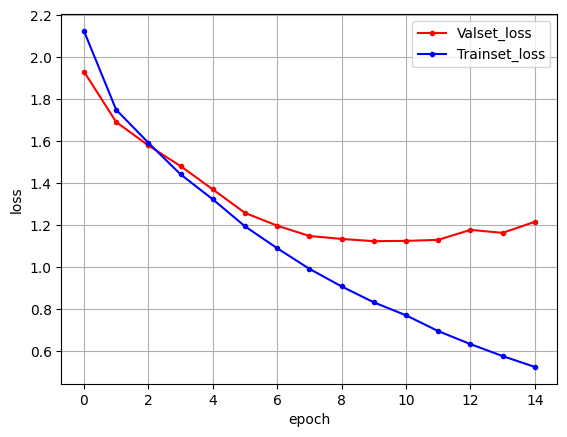

In [40]:
# 손실 그래프 시각화

# 검증 세트와 학습 세트의 손실 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프 생성
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Valset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프 설정
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()